In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import category_encoders as ce
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv("train_data.csv")
train_data = data

Посмотрим на данные в датасете. Выведем 5 первых наблюдений

In [3]:
train_data.head()

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


Посмотрим, какие значения принимают каждые параметры, среднее, среднее отклонение, минимальное и максимальное значения


In [4]:
train_data.describe()

,row_ID,current_mileage,vehicle_year,car_leather_interior,final_price
count,35000.000000,3.500000e+04,35000.000000,35000.000000,3.500000e+04
mean,17499.500000,1.969224e+06,2010.651743,0.715486,6.014077e+03
std,10103.774047,5.682401e+07,12.247792,0.451189,7.341517e+04
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,8749.750000,7.145400e+04,2008.000000,0.000000,1.350000e+03
50%,17499.500000,1.290000e+05,2012.000000,1.000000,3.900000e+03
75%,26249.250000,1.900000e+05,2014.000000,1.000000,7.000000e+03
max,34999.000000,2.147484e+09,2020.000000,1.000000,8.388607e+06


In [5]:
train_data.columns

Index(['row_ID', 'vehicle_manufacturer', 'vehicle_model', 'vehicle_category',
       'current_mileage', 'vehicle_year', 'vehicle_gearbox_type', 'doors_cnt',
       'wheels', 'vehicle_color', 'vehicle_interior_color', 'car_vin',
       'car_leather_interior', 'deal_type', 'final_price'],
      dtype='object')

In [6]:
train_data.dtypes

row_ID                      int64
vehicle_manufacturer       object
vehicle_model              object
vehicle_category           object
current_mileage             int64
vehicle_year                int64
vehicle_gearbox_type       object
doors_cnt                  object
wheels                     object
vehicle_color              object
vehicle_interior_color     object
car_vin                    object
car_leather_interior        int64
deal_type                  object
final_price               float64
dtype: object

Посмотрим, какие типы принимают признаки. Заметим, что doors_cnt -- это строка, поэтому к нему придётся использовать one-hot кодирование, либо переводить его в float. Попробуем применить оба подхода и сравним результат

In [7]:
train_data['deal_type'].value_counts()

For Sale    34372
For Rent      628
Name: deal_type, dtype: int64

In [8]:
train_data = train_data.query("deal_type == 'For Sale'")

In [9]:
train_data['deal_type'].value_counts()

For Sale    34372
Name: deal_type, dtype: int64

In [10]:
train_data.describe()

,row_ID,current_mileage,vehicle_year,car_leather_interior,final_price
count,34372.000000,3.437200e+04,34372.000000,34372.000000,3.437200e+04
mean,17504.892209,1.907385e+06,2010.707262,0.722449,6.119695e+03
std,10096.028634,5.584060e+07,12.312176,0.447797,7.407840e+04
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,8764.750000,7.149500e+04,2009.000000,0.000000,1.500000e+03
50%,17510.500000,1.290000e+05,2012.000000,1.000000,4.000000e+03
75%,26239.250000,1.905522e+05,2014.000000,1.000000,7.000000e+03
max,34999.000000,2.147484e+09,2020.000000,1.000000,8.388607e+06


In [11]:
train_data = train_data.query("final_price >= 200")

In [12]:
train_data.describe()

,row_ID,current_mileage,vehicle_year,car_leather_interior,final_price
count,31331.000000,3.133100e+04,31331.000000,31331.000000,3.133100e+04
mean,17508.256328,2.006425e+06,2010.575851,0.697520,6.703370e+03
std,10102.622331,5.721516e+07,5.965382,0.459339,7.756548e+04
min,0.000000,0.000000e+00,1940.000000,0.000000,2.000000e+02
25%,8736.500000,7.120050e+04,2008.000000,0.000000,2.209000e+03
50%,17524.000000,1.265990e+05,2012.000000,1.000000,4.486000e+03
75%,26249.500000,1.870000e+05,2014.000000,1.000000,7.500000e+03
max,34999.000000,2.147484e+09,2020.000000,1.000000,8.388607e+06


Посмотрели, какие значения принимает признак "deal_type". В датасете есть 628 автомобилей, сдающихся в аренду, их нужно выбросить, если в качестве целевой переменной брать стоимость продажи


In [13]:
train_data['current_mileage'].describe()

count    3.133100e+04
mean     2.006425e+06
std      5.721516e+07
min      0.000000e+00
25%      7.120050e+04
50%      1.265990e+05
75%      1.870000e+05
max      2.147484e+09
Name: current_mileage, dtype: float64

Посмотрим на значения пробега: видно, что среднее $1.9 \cdot 10^6$, а максимальное значение $2.14 \cdot 10^9$, скорее всего, есть выбросы по этому признаку, с ними нужно будет что-то сделать

In [14]:
train_data[train_data['current_mileage'] >= 10**6].count()

row_ID                    152
vehicle_manufacturer      152
vehicle_model             152
vehicle_category          152
current_mileage           152
vehicle_year              152
vehicle_gearbox_type      152
doors_cnt                 152
wheels                    152
vehicle_color             152
vehicle_interior_color    152
car_vin                    19
car_leather_interior      152
deal_type                 152
final_price               152
dtype: int64

Заметим, что всего у 74 автомобилей значение 'current_mileage' $\geq 10^7$, поэтому можно попробовать выбросить все эти значения 

In [15]:
train_data = train_data.query("current_mileage <= 1000000")

In [16]:
train_data['current_mileage'].describe()

count      31181.000000
mean      138696.510375
std       100078.857135
min            0.000000
25%        71000.000000
50%       126000.000000
75%       185881.000000
max      1000000.000000
Name: current_mileage, dtype: float64

In [17]:
train_data['vehicle_year'].describe()

count    31181.000000
mean      2010.621308
std          5.922361
min       1940.000000
25%       2008.000000
50%       2012.000000
75%       2014.000000
max       2020.000000
Name: vehicle_year, dtype: float64

In [18]:
train_data[train_data['vehicle_year'] <= 1920].count()

row_ID                    0
vehicle_manufacturer      0
vehicle_model             0
vehicle_category          0
current_mileage           0
vehicle_year              0
vehicle_gearbox_type      0
doors_cnt                 0
wheels                    0
vehicle_color             0
vehicle_interior_color    0
car_vin                   0
car_leather_interior      0
deal_type                 0
final_price               0
dtype: int64

Также есть выбросы в 'vehicle_year'. Будем рассматривать только те автомобили, которые выпущены раньше 1980-го года

In [19]:
train_data = train_data.query("vehicle_year >= 1940")

In [20]:
train_data['vehicle_year'].describe()

count    31181.000000
mean      2010.621308
std          5.922361
min       1940.000000
25%       2008.000000
50%       2012.000000
75%       2014.000000
max       2020.000000
Name: vehicle_year, dtype: float64

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

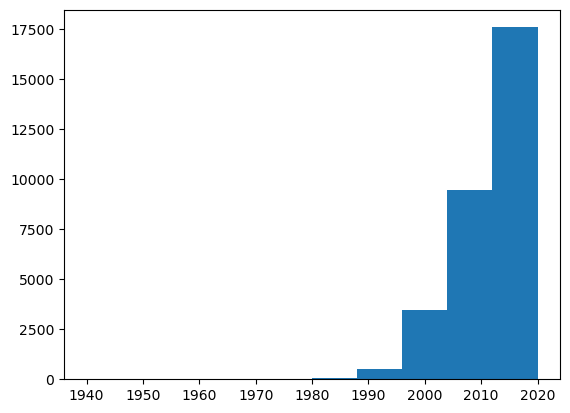

In [22]:
plt.hist(train_data['vehicle_year'])
plt.show()

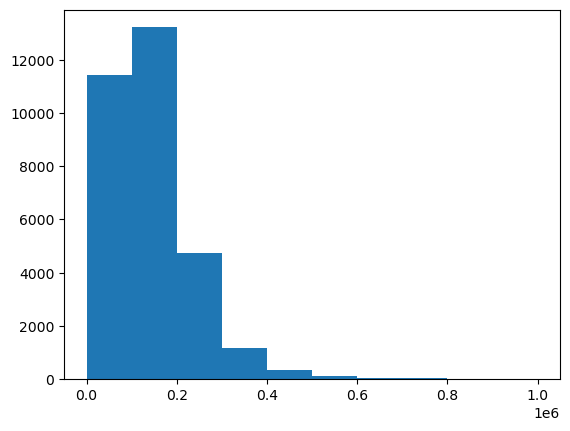

In [23]:
plt.hist(train_data['current_mileage'])
plt.show()

Из датасета удалим столбец с ID автомобиля

In [24]:
columns_to_drop = ['row_ID']

train_data = train_data.drop(columns = columns_to_drop)

In [25]:
train_data.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [26]:
train_data['car_vin'] = train_data['car_vin'].replace(np.nan, 0)
train_data['car_vin'] = train_data['car_vin'].replace('.*', 1, regex = True)

In [27]:
train_data.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,0,0,For Sale,3650.0
1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,0,0,For Sale,6800.0
2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,1,1,For Sale,6300.0
3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,0,1,For Sale,14488.0
4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,1,1,For Sale,5000.0


In [28]:
train_data = train_data.dropna()

train_data = train_data.drop(columns = ['deal_type'])

y = train_data['final_price']
X = train_data.drop(columns = ['final_price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.65, random_state = 42)

In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [30]:
numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns

categorical_data = X_train.select_dtypes([object])
categorical_features = categorical_data.columns

In [31]:
column_transform = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown = "ignore"), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('ohe and scaling', column_transform),
    ('Lasso regression', Lasso(alpha = 100))
])

In [32]:
model = pipeline.fit(X_train, y_train)

In [33]:
y_pred = model.predict(X_test)

In [34]:
from sklearn.metrics import mean_absolute_error

MAE_loss = mean_absolute_error(y_test, y_pred)

print(MAE_loss)

5157.156747136057


Lasso регуляризация занулила весов:

In [35]:
len(model.named_steps['Lasso regression'].coef_) - np.count_nonzero(model.named_steps['Lasso regression'].coef_)

1769

Попробуем использовать L2 регуляризацию, но для признаков vehicle_manufacturer, vehicle_model, vehicle_color применить target encoding, чтобы не раздувать пространство признаков.

In [36]:
y = train_data['final_price']
X = train_data.drop(columns = ['final_price'])


categorical_data = X.select_dtypes([object])
categorical_features = categorical_data.columns

In [37]:
categorical_features = categorical_features.drop(['vehicle_manufacturer'])
categorical_features = categorical_features.drop(['vehicle_model'])

print(categorical_features)

Index(['vehicle_category', 'vehicle_gearbox_type', 'doors_cnt', 'wheels',
       'vehicle_color', 'vehicle_interior_color'],
      dtype='object')


In [38]:
target_encoder = ce.TargetEncoder(X['vehicle_manufacturer'])
X['vehicle_manufacturer'] = target_encoder.fit_transform(X['vehicle_manufacturer'], y)
X.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior
0,5187.160262,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,0,0
1,7783.107917,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,0,0
2,8365.449099,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,1,1
3,8365.449099,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,0,1
6,8365.449099,Tucson,Jeep,173600,2013,Automatic,4/5,Left wheel,Silver,Black,0,1


In [39]:
target_encoder = ce.TargetEncoder(X['vehicle_model'])
X['vehicle_model'] = target_encoder.fit_transform(X['vehicle_model'], y)
X.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior
0,5187.160262,6610.584920,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,0,0
1,7783.107917,3676.476837,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,0,0
2,8365.449099,6996.655958,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,1,1
3,8365.449099,12822.725843,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,0,1
6,8365.449099,10594.800877,Jeep,173600,2013,Automatic,4/5,Left wheel,Silver,Black,0,1


In [40]:
numeric_data = X.select_dtypes([np.number])
numeric_features = numeric_data.columns

print(numeric_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.65, random_state = 42)

column_transform = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown = "ignore"), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('ohe and scaling', column_transform),
    ('regression', Ridge())
])

Index(['vehicle_manufacturer', 'vehicle_model', 'current_mileage',
       'vehicle_year', 'car_vin', 'car_leather_interior'],
      dtype='object')


In [41]:
model2 = pipeline.fit(X_train, y_train)

In [42]:
y_pred = model2.predict(X_test)

In [43]:
MAE_loss = mean_absolute_error(y_test, y_pred)

print(MAE_loss)

6186.3216666559365


In [44]:
print(len(model2.named_steps['regression'].coef_))

53


Подберём теперь оптимальный коэффициент регуляризации

In [45]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-10, 10, 100)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)

searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.65, random_state = 42)

column_transform = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown = "ignore"), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('ohe and scaling', column_transform),
    ('regression', Ridge(alpha = best_alpha))
])

model21 = pipeline.fit(X_train, y_train)

y_pred = model21.predict(X_test)

MAE_loss = mean_absolute_error(y_test, y_pred)

print(MAE_loss)

3638.2326076646464


Попробуем ещё улучшить качество нашей модели. Попробуем сделать бакеты с производителями автомобилей, а к 'vehicle_model' также будем применять target encoding. Такую же операцию проделаем и с цветом автомобиля

In [47]:
train_data['vehicle_color'].value_counts()

 White             6323
 Black             6113
 Silver            5169
 Grey              3153
 Blue              1993
 Red                893
 Green              539
 Carnelian red      343
 Orange             319
 Brown              301
 Beige              258
 Golden             237
 Sky blue           232
 Yellow             152
 Purple              57
 Pink                42
Name: vehicle_color, dtype: int64

In [48]:
manufacturer_counts = train_data['vehicle_manufacturer'].value_counts()
manufacturer_counts.describe()

count      66.000000
mean      395.818182
std      1014.943483
min         1.000000
25%         4.250000
50%        33.500000
75%       256.500000
max      5658.000000
Name: vehicle_manufacturer, dtype: float64

In [49]:
manufacturer_mean_price = train_data.groupby('vehicle_manufacturer')['final_price'].mean()

In [50]:
q25, q50, q75 = manufacturer_mean_price.quantile([0.25, 0.5, 0.75])

In [51]:
def manufacturer_to_numeric(manufacturer):
    mean_price = manufacturer_mean_price.get(manufacturer, 0)
    if mean_price <= q25:
        return 0
    elif q25 < mean_price <= q50:
        return 1
    elif q50 < mean_price <= q75:
        return 2
    else:
        return 3

In [52]:
X = train_data.drop(columns = ['final_price'])
y = train_data['final_price']

X['vehicle_manufacturer'] = X['vehicle_manufacturer'].apply(manufacturer_to_numeric)

In [53]:
X.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior
0,2,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,0,0
1,3,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,0,0
2,3,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,1,1
3,3,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,0,1
6,3,Tucson,Jeep,173600,2013,Automatic,4/5,Left wheel,Silver,Black,0,1


In [54]:
color_mean_price = train_data.groupby('vehicle_color')['final_price'].mean()

In [55]:
q25, q50, q75 = color_mean_price.quantile([0.25, 0.5, 0.75])

In [56]:
def color_to_numeric(manufacturer):
    mean_price = color_mean_price.get(manufacturer, 0)
    if mean_price <= q25:
        return 0
    elif q25 < mean_price <= q50:
        return 1
    elif q50 < mean_price <= q75:
        return 2
    else:
        return 3

In [57]:
X['vehicle_color'] = X['vehicle_color'].apply(color_to_numeric)

In [58]:
X.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior
0,2,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,1,Black,0,0
1,3,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,1,Black,0,0
2,3,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,1,Black,1,1
3,3,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,3,Black,0,1
6,3,Tucson,Jeep,173600,2013,Automatic,4/5,Left wheel,1,Black,0,1


In [59]:
target_encoder = ce.TargetEncoder(X['vehicle_model'])
X['vehicle_model'] = target_encoder.fit_transform(X['vehicle_model'], y)
X.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior
0,2,6610.584920,Sedan,133000,2014,Automatic,4/5,Right-hand drive,1,Black,0,0
1,3,3676.476837,Sedan,24500,2010,Manual,4/5,Left wheel,1,Black,0,0
2,3,6996.655958,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,1,Black,1,1
3,3,12822.725843,Jeep,115459,2015,Automatic,4/5,Left wheel,3,Black,0,1
6,3,10594.800877,Jeep,173600,2013,Automatic,4/5,Left wheel,1,Black,0,1


In [60]:
categorical_data = X.select_dtypes([object])
categorical_features = categorical_data.columns

numeric_data = X.select_dtypes([np.number])
numeric_features = numeric_data.columns

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.65, random_state = 42)

column_transform = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown = "ignore"), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('ohe and scaling', column_transform),
    ('regression', Ridge())
])

In [62]:
model3 = pipeline.fit(X_train, y_train)

In [63]:
y_pred = model3.predict(X_test)

In [64]:
MAE_loss = mean_absolute_error(y_test, y_pred)

print(MAE_loss)

5618.078009113937


In [65]:
print(len(model2.named_steps['regression'].coef_))

53


Точность улучшилась, но кардинального улучшения не вышло

In [66]:
manufacturer_counts = train_data['vehicle_model'].value_counts()
manufacturer_counts.describe()

count    2166.000000
mean       12.060942
std        75.480980
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      1788.000000
Name: vehicle_model, dtype: float64

In [67]:
y.describe()

count    2.612400e+04
mean     7.072037e+03
std      7.422059e+04
min      2.000000e+02
25%      2.800000e+03
50%      4.900000e+03
75%      7.845500e+03
max      8.388607e+06
Name: final_price, dtype: float64

In [68]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-10, 10, 100)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)

searcher.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ohe and scaling',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['vehicle_category', 'vehicle_gearbox_type', 'doors_cnt', 'wheels',
       'vehicle_interior_color'],
      dtype='object')),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         Index(['vehicle_manufacturer', 'vehicle_model', 'current_mileage',
       'vehic...
       2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05,
       1.45082878e+06, 2.31012970e+06, 3.67837977e+06, 5.85702082e+06,
       9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
       5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
       3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
       2.47707636e+09, 3.94420606e+09, 6.28029144e+09, 1.00000000e+10])}],
             scoring='neg_mean_absolute_error')

In [69]:
best_alpha = searcher.best_params_["regression__alpha"]

In [70]:
print("Best alpha = %.4f" % best_alpha)

Best alpha = 22051.3074


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.65, random_state = 42)

column_transform = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown = "ignore"), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('ohe and scaling', column_transform),
    ('regression', Ridge(alpha = best_alpha))
])

model4 = pipeline.fit(X_train, y_train)

y_pred = model4.predict(X_test)

MAE_loss = mean_absolute_error(y_test, y_pred)

print(MAE_loss)

3580.9364784859276


Попробуем теперь применить random forest для решения задачи

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.65, random_state = 42)

numeric_data = X.select_dtypes([np.number])
numeric_features = numeric_data.columns

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train[numeric_features])
X_test = scaler.transform(X_test[numeric_features])

regressor = RandomForestRegressor(n_estimators = 100, random_state = 42)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

MAE_loss = mean_absolute_error(y_test, y_pred)

print(MAE_loss)

2987.2128071786233


In [74]:
import xgboost as xgb

In [ ]:
regressor=xgb.XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.65, random_state = 42)

numeric_data = X.select_dtypes([np.number])
numeric_features = numeric_data.columns

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train[numeric_features])
X_test = scaler.transform(X_test[numeric_features])


from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    np.arange(2, 20),
              "n_estimators": np.arange(500, 1500, 100),
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(regressor, param_grid, cv=5, scoring="neg_mean_absolute_error").fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

In [ ]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric   = 'mae')

regressor.fit(X_train, y_train)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
mae_loss = mean_absolute_error(y_test, y_pred)
print(mae_loss)